*Megan Sharkey*
Week 9 Homework 

## **External Conditions**

First, import all packages needed to run the external conditions:

In [16]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

# import the necessary modules from eccoseas
from eccoseas.ecco import exf
from eccoseas.ecco import io
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

### Part 1: Download the ECCO external forcing fields

To begin, download the ECCO external forcing fields used in the ECCO Version 5 Alpha state estimate. I used the 2019 data files and stored them in the directory below:

In [17]:
data_folder = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 9'

### Part 2: Read in the external forcing fields

In order to read in these ECCO files, I used the *exf* module from the eccoseas package. 

In [18]:
# make a file dictionary to loop over
file_prefix_dict = {'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
                    'AQH':'EIG_spfh2m_plus_ECCO_v4r1_ctrl',
                    'SWDOWN':'EIG_dsw_plus_ECCO_v4r1_ctrl',
                    'LWDOWN':'EIG_dlw_plus_ECCO_v4r1_ctrl',
                    'UWIND':'EIG_u10m',
                    'VWIND':'EIG_v10m',
                    'PRECIP':'EIG_rain_plus_ECCO_v4r1_ctrl'}

variable_names = list(file_prefix_dict.keys())

In [19]:
# make a list to hold all of the exf grids
exf_grids = []
year=2019

# loop through each variable to read in the grid
for field in variable_names:
    exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(data_folder, file_prefix_dict[field], year)
    exf_grids.append(exf_grid)

Then, I make 2D grids of longitudes and latitudes to use in the interpolation. I visualize these in the plots below on a global scale.  

In [20]:
Exf_Lon, Exf_Lat = np.meshgrid(exf_lon, exf_lat)
ecco_points = np.column_stack([Exf_Lon.ravel(), Exf_Lat.ravel()])

In [21]:
ecco_meta_dict = {'ATEMP':[-50, 30, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-6, cm.tempo, 'm/s'],
             'SWDOWN':[-1000,0,cm.solar,'W/m$^2$'],
             'LWDOWN':[-500, 0,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-20, 20, cm.balance, 'm/s']}
ecco_variable_names = list(ecco_meta_dict.keys())

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p_/r3l2k0v15s16v1d1593p15400000gs/T/ipykernel_54972/3984358176.py:1: SyntaxWarning: invalid escape sequence '\c'
  ecco_meta_dict = {'ATEMP':[-50, 30, cm.thermal, '$^{\circ}$C'],


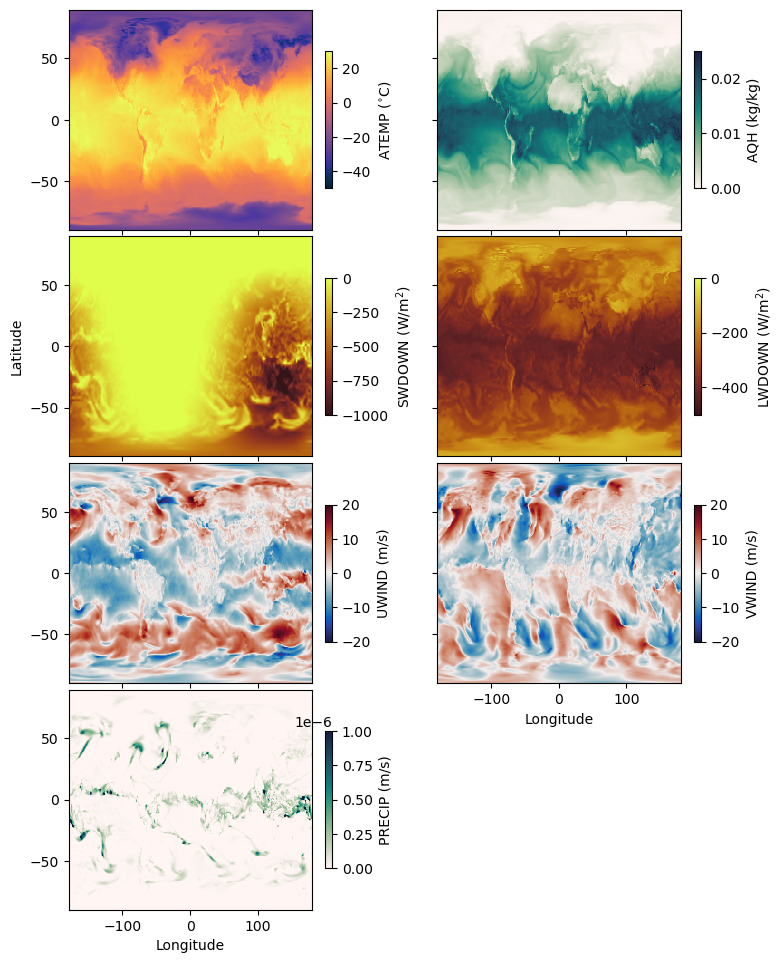

In [22]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i, exf_grid in enumerate(exf_grids):
    variable_name = ecco_variable_names[i]

    # choose just the first timestep for plotting
    exf_grid = exf_grid[0, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(Exf_Lon, Exf_Lat, exf_grid,
                       vmin=ecco_meta_dict[variable_names[i]][0],
                       vmax=ecco_meta_dict[variable_names[i]][1],
                       cmap=ecco_meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+ecco_meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

### Part 3: Reading in the Regional Greenland Model Grid

Next, I will recreate the grid that will be used in the regional Greenland model and read in the bathymetry file (see previous notebooks for details) in order to generate the land mask:

In [23]:
# define the input directory (constructed in the previous notebook for bathymetry)
# this directory should already have the bathymetry file called Greenland_bathymetry.bin
input_dir = os.getcwd()

In [24]:
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'Greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [25]:
# create the surface mask
# ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='DRF')
# delR = ecco_DRF_tiles[1]
depth = bathy
delR = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
          1.93,    2.20,    2.50,    2.84,   3.21,
          3.63,    4.10,    4.61,    5.18,   5.79,
          6.47,    7.20,    7.98,    8.83,   9.73,
         10.69,   11.70,   12.76,   13.87,  15.03,
         16.22,   17.45,   18.70,   19.97,  21.27,
         22.56,   23.87,   25.17,   26.46,  27.74,
         29.00,   30.24,   31.45,   32.65,  33.82,
         34.97,   36.09,   37.20,   38.29,  39.37])
surface_mask = hFac.create_hFacC_grid(bathy, delR)[0,:,:]
surface_mask[surface_mask>0]=1
surface_mask = surface_mask.astype(int)

Double check the mask was created correctly:

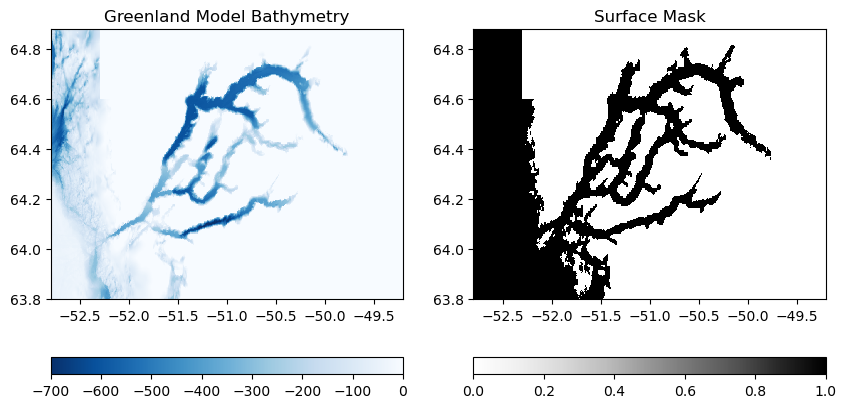

In [26]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-700, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Greenland Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

### Part 4: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields read in onto the regional Greenland model domain. 

In [27]:
# ensure the output folder exists
if 'exf' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir, 'exf'))

In [28]:
# tri is the interpolation model and only needs to be computed once
# it is reused after it is computed in the downscale function
tri = None

# loop through each variable and corresponding ECCO grid
for variable_name, exf_grid in zip(variable_names, exf_grids):

    # print a message to keep track of which variable we are working on
    print('    - Interpolating the '+variable_name+' grid')

    # create a grid of zeros to fill in
    interpolated_grid, tri = horizontal.downscale_exf_field(ecco_points, exf_grid,
                                                          XC, YC, surface_mask, tri)

    # convert ECCO values to MITgcm defaults
    if variable_name=='ATEMP':
        interpolated_grid += 273.15
    if variable_name in ['SWDOWN','LWDOWN']:
        interpolated_grid *=-1

    # output the interpolated grid
    output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ATEMP grid
    - Interpolating the AQH grid
    - Interpolating the SWDOWN grid
    - Interpolating the LWDOWN grid
    - Interpolating the UWIND grid
    - Interpolating the VWIND grid
    - Interpolating the PRECIP grid


### Part 5: Plotting the External Forcing Fields
Now that the fields have been generated, I plot them below to make sure they look as expected. 

In [29]:
meta_dict = {'ATEMP':[270, 280, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.0065, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-7, cm.tempo, 'm/s'],
             'SWDOWN':[0, 500,cm.solar,'W/m$^2$'],
             'LWDOWN':[0, 500,cm.solar,'W/m$^2$'],
             'UWIND':[-5, 5, cm.balance, 'm/s'],
             'VWIND':[-5, 5, cm.balance, 'm/s'],
             'RUNOFF':[0, 2e-8, cm.tempo, 'm/s']}

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p_/r3l2k0v15s16v1d1593p15400000gs/T/ipykernel_54972/732948413.py:1: SyntaxWarning: invalid escape sequence '\c'
  meta_dict = {'ATEMP':[270, 280, cm.thermal, '$^{\circ}$C'],


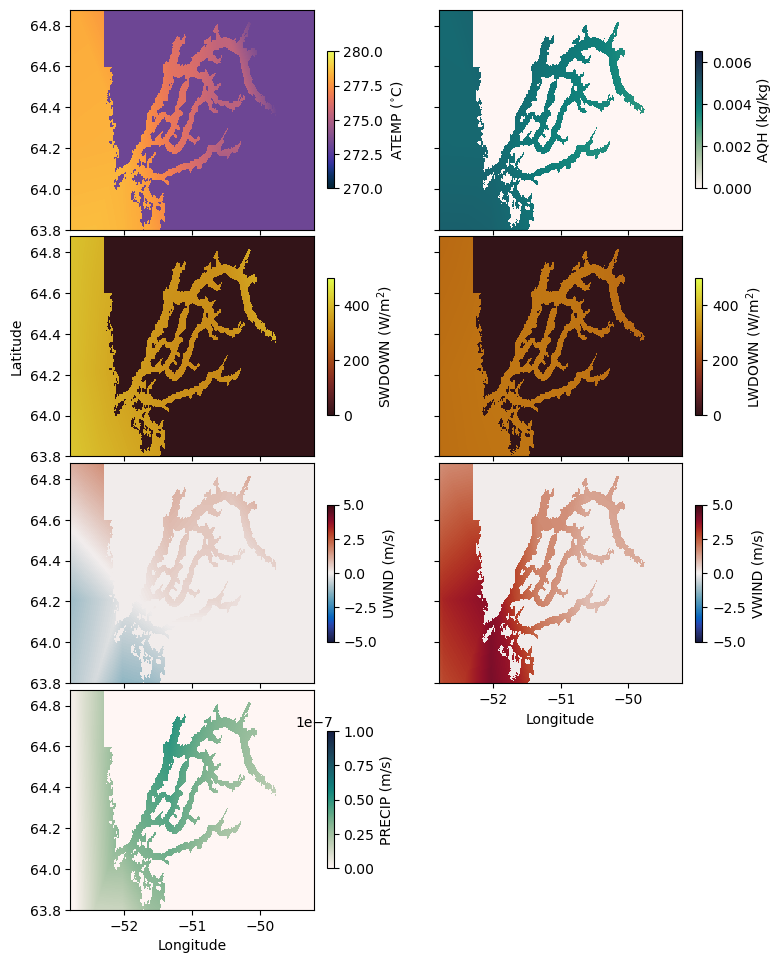

In [30]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    Greenland_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    Greenland_exf_grid = Greenland_exf_grid.reshape((np.shape(exf_grid)[0],np.shape(XC)[0], np.shape(XC)[1]))

    # choose just the first timestep for plotting
    Greenland_exf_grid = Greenland_exf_grid[1002, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, Greenland_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()